In [ ]:
!pip install rasterio -q
!pip install pint -q
!pip install cartopy -q

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rasterio
from shapely.geometry import Point
from shapely import wkt
from shapely.ops import unary_union

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pint import UnitRegistry
from collections import defaultdict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 93.8 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
obs_folder = '/content/drive/MyDrive/data_scriptie/observation_data/selection'
site_folder = '/content/drive/MyDrive/data_scriptie/site_info/selection'

obs_files = [f for f in os.listdir(obs_folder) if f.endswith('.txt')]
merged_data = {}

for obs_file in obs_files:
    pollutant_name = obs_file.replace(".txt", "")
    obs_path = os.path.join(obs_folder, obs_file)
    site_path = os.path.join(site_folder, obs_file)
    if os.path.exists(site_path):
        df_obs = pd.read_csv(obs_path, sep="\t")
        df_sites = pd.read_csv(site_path, sep="\t")
        df_merged = df_obs.merge(df_sites, on="site_id", how="left")
        df_merged["pollutant"] = pollutant_name
        merged_data[pollutant_name] = df_merged
    else:
        print(f"⚠️ Site-info is missing for: {obs_file}")

df_EC = merged_data.get("EC_SW")


In [ ]:
for name, df in merged_data.items():
    print(f"{name} heeft {len(df)} rijen en kolommen: {df.columns.tolist()}")

Carbamazepine_SW heeft 6558 rijen en kolommen: ['site_id', 'dates', 'obs', 'unit', 'database_x', 'Latitude', 'Longitude', 'database_y', 'nObs', 'variable', 'group', 'sub_group', 'country_name', 'hydbas', 'pollutant']
Diclofenac_SW heeft 21908 rijen en kolommen: ['site_id', 'dates', 'obs', 'unit', 'database_x', 'Latitude', 'Longitude', 'database_y', 'nObs', 'variable', 'group', 'sub_group', 'country_name', 'hydbas', 'pollutant']
DO_SW heeft 4711967 rijen en kolommen: ['site_id', 'dates', 'obs', 'unit', 'database_x', 'Latitude', 'Longitude', 'database_y', 'nObs', 'variable', 'group', 'sub_group', 'country_name', 'hydbas', 'pollutant']
PFOS_SW heeft 16554 rijen en kolommen: ['site_id', 'dates', 'obs', 'unit', 'database_x', 'Latitude', 'Longitude', 'database_y', 'nObs', 'variable', 'group', 'sub_group', 'country_name', 'hydbas', 'pollutant']
TSS_SW heeft 3142885 rijen en kolommen: ['site_id', 'dates', 'obs', 'unit', 'database_x', 'Latitude', 'Longitude', 'database_y', 'nObs', 'variable', '

In [ ]:
gdf_data = {}

for name, df in merged_data.items():
    if "Longitude" in df.columns and "Latitude" in df.columns:
        df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
        gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
        gdf_data[name] = gdf

gdf_data["DO_SW"].head()


,site_id,dates,obs,unit,database_x,Latitude,Longitude,database_y,nObs,variable,group,sub_group,country_name,hydbas,pollutant,geometry
0,88977,2011-09-28,9.63,mg/L,DWS,-27.10371,26.52153,DWS,5,DO,chemical,oxygen,South Africa,1091611380,DO_SW,POINT (26.52153 -27.10371)
1,88977,2011-10-18,7.28,mg/L,DWS,-27.10371,26.52153,DWS,5,DO,chemical,oxygen,South Africa,1091611380,DO_SW,POINT (26.52153 -27.10371)
2,88977,2011-11-15,3.86,mg/L,DWS,-27.10371,26.52153,DWS,5,DO,chemical,oxygen,South Africa,1091611380,DO_SW,POINT (26.52153 -27.10371)
3,88977,2012-07-31,3.04,mg/L,DWS,-27.10371,26.52153,DWS,5,DO,chemical,oxygen,South Africa,1091611380,DO_SW,POINT (26.52153 -27.10371)
4,88977,2012-08-29,3.06,mg/L,DWS,-27.10371,26.52153,DWS,5,DO,chemical,oxygen,South Africa,1091611380,DO_SW,POINT (26.52153 -27.10371)


In [ ]:
unit_counts = {}

for name, gdf in gdf_data.items():
    if "variable" in gdf.columns and "unit" in gdf.columns:
        df_clean = gdf[["variable", "unit"]].dropna().copy()
        df_clean["variable"] = df_clean["variable"].astype(str).str.strip().str.lower()
        df_clean["unit"] = df_clean["unit"].astype(str).str.strip().str.lower()
        counts = (
            df_clean
            .groupby(["variable", "unit"])
            .size()
            .reset_index(name="count")
            .sort_values(by=["variable", "count"], ascending=[True, False])
        )

        unit_counts[name] = counts


In [ ]:
for pollutant, df_units in unit_counts.items():
    print(f"\n {pollutant}")
    for _, row in df_units.iterrows():
        print(f"  - {row['variable']}: {row['unit']} ({row['count']})")




 Carbamazepine_SW
  - carbamazepine: ug/l (3704)
  - carbamazepine: µg/l (2728)
  - carbamazepine: % recovery (102)
  - carbamazepine: ng/l (24)

 Diclofenac_SW
  - diclofenac: ug/l (19055)
  - diclofenac: µg/l (2664)
  - diclofenac: % recovery (134)
  - diclofenac: ng/l (40)
  - diclofenac: ug/kg (15)

 DO_SW
  - do: mg/l (4498099)
  - do: mgo2/l (140700)
  - do: % (58290)
  - do: ppm (12500)
  - do: us/cm (440)
  - do: deg c (245)
  - do: ug/l (231)
  - do: m (123)
  - do: mg/ml (80)
  - do: in (74)
  - do: days (73)
  - do: umho/cm (20)
  - do: g/ml (11)
  - do: #/100ml (7)
  - do: count (7)
  - do: ml/l (5)
  - do: ms/cm (4)
  - do: deg f (2)
  - do: mg (2)
  - do: ntu (2)
  - do: g/l (1)
  - do: mg/kg (1)
  - do: nu (1)
  - do: ppt (1)

 PFOS_SW
  - pfos: µg/l (14913)
  - pfos: ng/l (1575)
  - pfos: % recovery (55)
  - pfos: ug/l (7)
  - pfos: % (2)
  - pfos: ng/kg (2)

 TSS_SW
  - tss: mg/l (3131648)
  - tss: % (6093)
  - tss: ppm (4061)
  - tss: ug/l (478)
  - tss: g (245)
  - 

In [ ]:
ureg = UnitRegistry()
Q_ = ureg.Quantity

ureg.define('ug = microgram = µg')
ureg.define('l = liter')
ureg.define('mg = milligram')
ureg.define('ng = nanogram')
ureg.define('ppm = parts_per_million')
ureg.define('ppb = parts_per_billion')

target_unit = {}
for name, df_units in unit_counts.items():
    meest_voorkomende = (
        df_units
        .sort_values(["variable", "count"], ascending=[True, False])
        .groupby("variable", as_index=False)
        .first()
    )
    var2unit = dict(zip(meest_voorkomende["variable"], meest_voorkomende["unit"]))
    target_unit[name] = var2unit

def convert_value(value, from_unit_str, to_unit_str):
    if pd.isna(value):
        return np.nan
    if pd.isna(from_unit_str) or pd.isna(to_unit_str):
        return np.nan
    u_from_raw = str(from_unit_str).strip().lower()
    u_to_raw   = str(to_unit_str).strip().lower()
    u_from = u_from_raw.replace("µ", "u").replace(" ", "")
    u_to   = u_to_raw  .replace("µ", "u").replace(" ", "")

    try:
        q = Q_(value, u_from)
        q_to = q.to(u_to)
        return q_to.magnitude
    except Exception:
        return np.nan

gdf_data_std = {}

for name, gdf in gdf_data.items():
    value_col = "obs"

    if ("variable" not in gdf.columns) or ("unit" not in gdf.columns) or (value_col not in gdf.columns):
        print(f"⚠️ Columns 'variable', 'unit' or '{value_col}' missing in: {name} – skip.")
        continue

    df = gdf.copy()
    var2target = target_unit.get(name, {})
    if not var2target:
        continue
    df["target_unit"] = df["variable"].str.strip().str.lower().map(var2target)
    df["obs_std"] = np.nan
    mask_correct = (
        df["unit"].astype(str).str.strip().str.lower() ==
        df["target_unit"].astype(str).str.strip().str.lower()
    )
    df.loc[mask_correct, "obs_std"] = df.loc[mask_correct, value_col]
    mask_to_convert = (~mask_correct) & (~df["target_unit"].isna())
    for idx in df[mask_to_convert].index:
        orig_val = df.at[idx, value_col]
        orig_unit = df.at[idx, "unit"]
        tgt_unit = df.at[idx, "target_unit"]
        geconverteerd = convert_value(orig_val, orig_unit, tgt_unit)
        df.at[idx, "obs_std"] = geconverteerd
    df_clean = df[df["obs_std"].notna()].copy()
    df_clean[value_col] = df_clean["obs_std"]
    df_clean["unit"] = df_clean["target_unit"]
    df_clean = df_clean.drop(columns=["obs_std", "target_unit"]).reset_index(drop=True)
    gdf_data_std[name] = gpd.GeoDataFrame(df_clean, geometry=df_clean.geometry, crs=df_clean.crs)

for name, gdf_std in gdf_data_std.items():
    print(f"\n{name} na standaardisatie (kolommen ['variable', 'obs', 'unit']):")
    print(gdf_std[["variable", "obs", "unit"]].head())



Carbamazepine_SW na standaardisatie (kolommen ['variable', 'obs', 'unit']):
        variable     obs  unit
0  Carbamazepine  0.0184  ug/l
1  Carbamazepine  0.0145  ug/l
2  Carbamazepine  0.0104  ug/l
3  Carbamazepine  0.0101  ug/l
4  Carbamazepine  0.0115  ug/l

Diclofenac_SW na standaardisatie (kolommen ['variable', 'obs', 'unit']):
     variable    obs  unit
0  Diclofenac  0.426  ug/l
1  Diclofenac  0.137  ug/l
2  Diclofenac  0.224  ug/l
3  Diclofenac  0.150  ug/l
4  Diclofenac  0.456  ug/l

DO_SW na standaardisatie (kolommen ['variable', 'obs', 'unit']):
  variable   obs  unit
0       DO  9.63  mg/l
1       DO  7.28  mg/l
2       DO  3.86  mg/l
3       DO  3.04  mg/l
4       DO  3.06  mg/l

PFOS_SW na standaardisatie (kolommen ['variable', 'obs', 'unit']):
  variable    obs  unit
0     PFOS  0.002  µg/l
1     PFOS  0.002  µg/l
2     PFOS  0.002  µg/l
3     PFOS  0.002  µg/l
4     PFOS  0.002  µg/l

TSS_SW na standaardisatie (kolommen ['variable', 'obs', 'unit']):
  variable    obs 

In [ ]:
import geopandas as gpd

def remove_within_station_outliers_fast(gdf, z_thresh=2.5):
    """
    Removes all rows where obs > (group_mean + z_thresh * group_std), for each site_id.
    This version uses groupby.transform to compute per-row thresholds in a vectorized way.

    Input:
      - gdf: a GeoDataFrame containing at least ['site_id', 'obs', 'geometry'] (and any other columns).
      - z_thresh: how many standard deviations above the mean we consider an outlier.

    Returns:
      - A new GeoDataFrame with the same CRS/geometry, but with outliers removed.
    """
    # 1) Copy only the numeric columns + site_id (drop geometry for now to save memory)
    df = gdf.drop(columns="geometry").copy()

    # 2) Compute per-row group mean and group std of 'obs'
    #    transform('mean') and transform('std') each return a Series aligned with df.index
    group_mean = df.groupby("site_id")["obs"].transform("mean")
    group_std  = df.groupby("site_id")["obs"].transform("std")

    # 3) Build a boolean mask: keep rows where obs <= mean + z_thresh * std
    threshold = group_mean + z_thresh * group_std
    mask_keep = df["obs"] <= threshold

    # 4) Filter the DataFrame
    df_clean = df.loc[mask_keep].copy()

    # 5) Now reattach the geometry (and any other dropped columns) from the original GeoDataFrame
    #    We know df_clean.index corresponds to gdf.index for the kept rows
    gdf_clean = gdf.loc[df_clean.index].copy()

    # 6) Reset index if you prefer
    gdf_clean = gdf_clean.reset_index(drop=True)
    return gdf_clean


gdf_data_no_outliers = {}

for name, gdf_std in gdf_data_std.items():
    gdf_clean = remove_within_station_outliers_fast(gdf_std, z_thresh=2.5)
    gdf_data_no_outliers[name] = gdf_clean

# Quick check:
for name in gdf_data_std:
    n_before = len(gdf_data_std[name])
    n_after  = len(gdf_data_no_outliers[name])
    print(f"{name}: before = {n_before} rows, after = {n_after} rows")


Carbamazepine_SW: before = 6456 rows, after = 6384 rows
Diclofenac_SW: before = 21759 rows, after = 21133 rows
DO_SW: before = 4498422 rows, after = 4396493 rows
PFOS_SW: before = 16495 rows, after = 15900 rows
TSS_SW: before = 3132343 rows, after = 2999695 rows
TN_SW: before = 845126 rows, after = 820443 rows


In [ ]:
def balance_by_top3_countries(gdf, country_col="country_name", random_state=42):
    """
    Balances a GeoDataFrame by downsampling the top 3 countries to the size of the 3rd largest,
    while keeping all other countries untouched.

    Steps:
    1) Count the number of rows per country.
    2) Identify the top 3 countries and determine the 'third count' (size of the 3rd largest).
    3) For each of the top 3 countries: sample exactly 'third count' rows.
    4) For all other countries: retain all rows as-is.
    5) Concatenate and shuffle the final result.

    Returns a new GeoDataFrame with the same structure and geometry.
    """
    df = gdf.copy()
    counts = df[country_col].value_counts()

    if len(counts) < 3:
        return gdf.copy()

    top3 = counts.index[:3]
    n_third = int(counts.iloc[2])

    parts = []

    mask_outside = ~df[country_col].isin(top3)
    parts.append(df[mask_outside])

    for country in top3:
        subset = df[df[country_col] == country]
        if len(subset) <= n_third:
            parts.append(subset)
        else:
            parts.append(subset.sample(n=n_third, random_state=random_state))

    df_balanced = pd.concat(parts, ignore_index=True)
    df_balanced = df_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)

    gdf_balanced = gpd.GeoDataFrame(df_balanced, geometry=df_balanced.geometry, crs=gdf.crs)
    return gdf_balanced


gdf_data_balanced = {}

for name, gdf_clean in gdf_data_no_outliers.items():
    gdf_bal = balance_by_top3_countries(gdf_clean, country_col="country_name", random_state=42)
    gdf_data_balanced[name] = gdf_bal
    print(f"{name}: before = {len(gdf_clean)} rows, after = {len(gdf_bal)} rows")

Carbamazepine_SW: before = 6384 rows, after = 1503 rows
Diclofenac_SW: before = 21133 rows, after = 6685 rows
DO_SW: before = 4396493 rows, after = 869014 rows
PFOS_SW: before = 15900 rows, after = 12785 rows
TSS_SW: before = 2999695 rows, after = 765101 rows
TN_SW: before = 820443 rows, after = 491430 rows


In [ ]:
# Remove negative and extreme values (1st–99th percentile) from each \
# GeoDataFrame and summarize the filtering effect

gdf_data_filtered = {}
summary = []

for name, gdf in gdf_data_balanced.items():
    var_name = gdf["variable"].iloc[0]

    gdf = gdf[gdf["obs"] >= 0].copy()
    p1 = gdf["obs"].quantile(0.01)
    p99 = gdf["obs"].quantile(0.99)

    before_count = len(gdf)
    mask = (gdf["obs"] >= p1) & (gdf["obs"] <= p99)
    gdf_filtered = gdf[mask].copy()
    after_count = len(gdf_filtered)

    gdf_data_filtered[name] = gdf_filtered

    summary.append({
        "dataset": name,
        "variable": var_name,
        "count_before": before_count,
        "count_after": after_count,
        "1st_percentile": round(p1, 4),
        "99th_percentile": round(p99, 4)
    })

df_summary = pd.DataFrame(summary)
print(df_summary)


            dataset       variable  count_before  count_after  1st_percentile  \
0  Carbamazepine_SW  Carbamazepine          1503         1487           0.001   
1     Diclofenac_SW     Diclofenac          6685         6558           0.003   
2             DO_SW             DO        866135       851164           1.000   
3           PFOS_SW           PFOS         12785        12686           0.000   
4            TSS_SW            TSS        765000       750142           0.500   
5             TN_SW             TN        491396       481617           0.045   

   99th_percentile  
0           0.4696  
1           0.7316  
2          14.6000  
3           2.0000  
4         400.0000  
5          29.6068  


In [ ]:
import pandas as pd
import geopandas as gpd

# 1) Define reasonable min/max “logical” ranges for each pollutant.
#    Adjust these bounds as needed based on your domain knowledge.
logical_ranges = {
    "Carbamazepine": (0.001, 0.4696),  # µg/L
    "Diclofenac":   (0.003, 0.7316),   # µg/L
    "DO":           (1, 14.6),  # mg/L
    "PFOS":         (0, 2),   # µg/L
    "TSS":          (0, 400),# mg/L
    "TN":           (0.045, 29.6068)   # mg/L
}

# 2) Prepare a dictionary to hold the filtered GeoDataFrames,
#    and a list for summarizing counts before/after.
gdf_data_filtered = {}
summary = []

# 3) Loop over each balanced GeoDataFrame
for name, gdf in gdf_data_balanced.items():
    # Assume each GeoDataFrame’s “variable” column is constant (e.g. “DO”, “TSS”, etc.)
    var_name = gdf["variable"].iloc[0]

    # If we have no logical range for this variable, just copy it untouched
    if var_name not in logical_ranges:
        gdf_data_filtered[name] = gdf.copy()
        summary.append({
            "dataset":      name,
            "variable":     var_name,
            "count_before": len(gdf),
            "count_after":  len(gdf),
            "filtered":     False
        })
        continue

    min_val, max_val = logical_ranges[var_name]
    before_count = len(gdf)
    mask = (gdf["obs"] >= min_val) & (gdf["obs"] <= max_val)
    gdf_filtered = gdf[mask].copy()
    after_count = len(gdf_filtered)

    # Store the filtered GeoDataFrame
    gdf_data_filtered[name] = gdf_filtered

    # Record counts
    summary.append({
        "dataset":      name,
        "variable":     var_name,
        "count_before": before_count,
        "count_after":  after_count,
        "filtered":     True
    })

# 4) view
df_summary = pd.DataFrame(summary)
print(df_summary)


            dataset       variable  count_before  count_after  filtered
0  Carbamazepine_SW  Carbamazepine          1503         1487      True
1     Diclofenac_SW     Diclofenac          6685         6558      True
2             DO_SW             DO        869014       851164      True
3           PFOS_SW           PFOS         12785        12735      True
4            TSS_SW            TSS        765101       757439      True
5             TN_SW             TN        491430       481617      True


In [ ]:
import pandas as pd
import geopandas as gpd

# Create a new dict for GeoDataFrames containing only obs ≥ 2010
gdf_data_recent = {}
summary_date = []

for name, gdf in gdf_data_filtered.items():
    df_copy = gdf.copy()
    df_copy['dates'] = pd.to_datetime(df_copy['dates'])
    mask_recent = df_copy['dates'].dt.year >= 2010
    df_recent = df_copy[mask_recent].copy()
    gdf_data_recent[name] = gpd.GeoDataFrame(df_recent, geometry=df_recent.geometry, crs=gdf.crs)
    summary_date.append({
        "dataset":      name,
        "count_before": len(gdf),
        "count_after":  len(df_recent),
        "years_kept":   ">=2010"
    })

# Build a summary DataFrame to verify how many rows were kept
df_summary_date = pd.DataFrame(summary_date)
print(df_summary_date)


            dataset  count_before  count_after years_kept
0  Carbamazepine_SW          1487         1468     >=2010
1     Diclofenac_SW          6558         6516     >=2010
2             DO_SW        851164       613778     >=2010
3           PFOS_SW         12735        12731     >=2010
4            TSS_SW        757439       442869     >=2010
5             TN_SW        481617       286905     >=2010


In [ ]:
# Iterate over each GeoDataFrame in gdf_data_recent and add a “month” column

for name, gdf in gdf_data_recent.items():
    gdf["dates"] = pd.to_datetime(gdf["dates"], format="%Y-%m-%d")

    gdf["year"]       = gdf["dates"].dt.year
    gdf["month"]      = gdf["dates"].dt.month
    gdf["day"]        = gdf["dates"].dt.day
    gdf["dayofyear"]  = gdf["dates"].dt.dayofyear
    gdf["weekday"]    = gdf["dates"].dt.weekday
    gdf["month_sin"]  = np.sin(2 * np.pi * gdf["month"]      / 12)
    gdf["month_cos"]  = np.cos(2 * np.pi * gdf["month"]      / 12)
    gdf["doy_sin"]    = np.sin(2 * np.pi * gdf["dayofyear"]  / 365)
    gdf["doy_cos"]    = np.cos(2 * np.pi * gdf["dayofyear"]  / 365)
    gdf_data_recent[name] = gdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 65.4 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


Carbamazepine_SW: 1470 / 1484 points on land
Diclofenac_SW: 6529 / 6640 points on land
DO_SW: 606516 / 620814 points on land
PFOS_SW: 12150 / 12491 points on land
TSS_SW: 435336 / 446671 points on land
TN_SW: 283842 / 289259 points on land


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


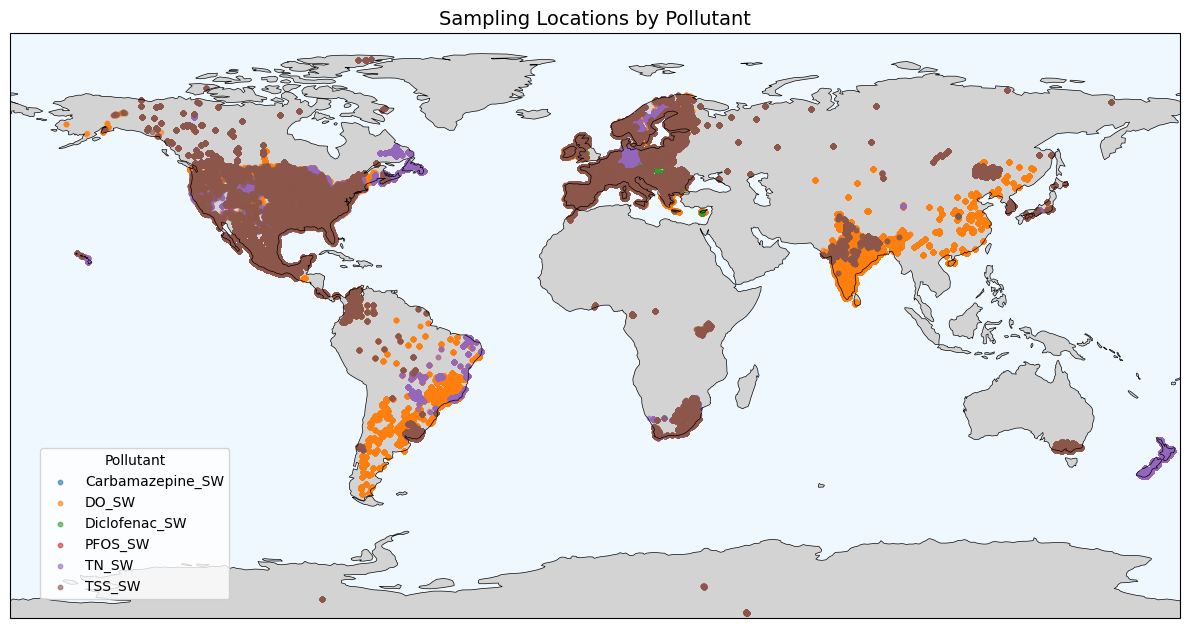

In [ ]:
# -------------------------------------------------
# 1) Build a single “land” geometry from Cartopy
# -------------------------------------------------
land_feat = cfeature.NaturalEarthFeature('physical', 'land', '110m')
land_geom = unary_union(list(land_feat.geometries()))

# -------------------------------------------------
# 2) Filter out any points that fall in the ocean
# -------------------------------------------------
cleaned_data = {}
for name, gdf in gdf_data_recent.items():
    pts = gdf.to_crs(epsg=4326).copy()
    on_land = pts.geometry.within(land_geom)
    clean = pts[on_land].copy()
    cleaned_data[name] = clean
    print(f"{name}: {len(clean)} / {len(pts)} points on land")

# -------------------------------------------------
# 3) Define a plotting function (Cartopy)
# -------------------------------------------------
def plot_locations_with_coastlines_cartopy(
    data_dict,
    extent=(-180, 180, -90, 90),
    figsize=(12, 8),
    markersize=10,
    alpha=0.6):
    """
    Plot cleaned sampling points by pollutant on a global map with Cartopy coastlines.
    """
    tagged = []
    for name, gdf in data_dict.items():
        tmp = gdf.to_crs(epsg=4326).copy()
        tmp['pollutant'] = name
        tmp['lon'] = tmp.geometry.x
        tmp['lat'] = tmp.geometry.y
        tagged.append(tmp[['lon','lat','pollutant']])
    combined = pd.concat(tagged, ignore_index=True)

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines(resolution='110m', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='aliceblue')

    for pol, df in combined.groupby('pollutant'):
        ax.scatter(
            df['lon'], df['lat'],
            label=pol,
            s=markersize,
            alpha=alpha,
            transform=ccrs.PlateCarree()
        )

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_title('Sampling Locations by Pollutant', fontsize=14)
    ax.legend(title='Pollutant', loc='lower left', bbox_to_anchor=(0.02, 0.02))
    plt.tight_layout()
    plt.show()

plot_locations_with_coastlines_cartopy(cleaned_data)


In [ ]:
# Assuming you’ve already built `gdf_data_recent` as shown earlier,
# where each key is the dataset name (e.g. “DO_SW”) and the value is
# a GeoDataFrame filtered for dates ≥ 2010.

import os

output_dir = "/content/drive/MyDrive/data_scriptie/Output/pollutants"
os.makedirs(output_dir, exist_ok=True)

for name, gdf in cleaned_data.items():
    df = gdf.drop(columns="geometry")
    filename = f"{name}.csv"
    path = os.path.join(output_dir, filename)
    df.to_csv(path, index=False)
    print(f"Saved {name} → {path}")


Saved Carbamazepine_SW → /content/drive/MyDrive/data_scriptie/Output/pollutants/Carbamazepine_SW.csv
Saved Diclofenac_SW → /content/drive/MyDrive/data_scriptie/Output/pollutants/Diclofenac_SW.csv
Saved DO_SW → /content/drive/MyDrive/data_scriptie/Output/pollutants/DO_SW.csv
Saved PFOS_SW → /content/drive/MyDrive/data_scriptie/Output/pollutants/PFOS_SW.csv
Saved TSS_SW → /content/drive/MyDrive/data_scriptie/Output/pollutants/TSS_SW.csv
Saved TN_SW → /content/drive/MyDrive/data_scriptie/Output/pollutants/TN_SW.csv


In [ ]:
monthly_data = {}

for pol, gdf in cleaned_data.items():
    gdf = gdf.copy()
    gdf['dates'] = pd.to_datetime(gdf['dates'])
    gdf['year']  = gdf['dates'].dt.year
    gdf['month'] = gdf['dates'].dt.month

    m_gdf = gpd.GeoDataFrame(
        gdf,
        geometry=gpd.points_from_xy(gdf.Longitude, gdf.Latitude),
        crs=gdf.crs
    )
    m_gdf['Longitude'] = m_gdf.geometry.x
    m_gdf['Latitude']  = m_gdf.geometry.y

    monthly_data[pol] = m_gdf

    print(f"{pol}: save {len(gdf)} monthly rows")


Carbamazepine_SW: bewaar 1470 maandelijkse rijen (geen aggregatie)
Diclofenac_SW: bewaar 6529 maandelijkse rijen (geen aggregatie)
DO_SW: bewaar 606516 maandelijkse rijen (geen aggregatie)
PFOS_SW: bewaar 12150 maandelijkse rijen (geen aggregatie)
TSS_SW: bewaar 435336 maandelijkse rijen (geen aggregatie)
TN_SW: bewaar 283842 maandelijkse rijen (geen aggregatie)


In [ ]:
output_dir = "/content/drive/MyDrive/data_scriptie/Output/pollutants_monthly"
os.makedirs(output_dir, exist_ok=True)

for name, gdf in monthly_data.items():
    # Convert GeoDataFrame to a regular DataFrame if you prefer to drop geometry
    df = gdf.drop(columns="geometry")

    # Build a filename based on the dataset name
    filename = f"{name}.csv"
    path = os.path.join(output_dir, filename)

    # Save to CSV (no index column)
    df.to_csv(path, index=False)
    print(f"Saved {name} → {path}")


Saved Carbamazepine_SW → /content/drive/MyDrive/data_scriptie/Output/pollutants_monthly/Carbamazepine_SW.csv
Saved Diclofenac_SW → /content/drive/MyDrive/data_scriptie/Output/pollutants_monthly/Diclofenac_SW.csv
Saved DO_SW → /content/drive/MyDrive/data_scriptie/Output/pollutants_monthly/DO_SW.csv
Saved PFOS_SW → /content/drive/MyDrive/data_scriptie/Output/pollutants_monthly/PFOS_SW.csv
Saved TSS_SW → /content/drive/MyDrive/data_scriptie/Output/pollutants_monthly/TSS_SW.csv
Saved TN_SW → /content/drive/MyDrive/data_scriptie/Output/pollutants_monthly/TN_SW.csv
